In [ ]:
# CIFAR-10 PCA + QDA/KNN pipeline with cross-validation and validation evaluation
# Full version and documentation: https://github.com/xyb271828/
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Config
DATA_PATH = "./data/train_cifar10.npz"   # ensure this file is present
USE_QDA = True                           # set False to try KNN
RNG, VAL_SIZE, CV_FOLDS = 42, 0.2, 5
PCA_GRID = list(range(10, 101, 10))      # number of components to try

CIFAR10_LABELS = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [3]:
# Utilities
def visualize_images(X_vis, y, num_images=10, start_index=0):
    """Show a row of images with class titles."""
    end = min(start_index + num_images, len(X_vis))
    cols = end - start_index
    plt.figure(figsize=(1.8 * cols, 1.8))
    for i, idx in enumerate(range(start_index, end), 1):
        ax = plt.subplot(1, cols, i)
        ax.imshow(X_vis[idx])
        ax.set_title(CIFAR10_LABELS.get(int(y[idx]), str(int(y[idx]))), fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def plot_incorrect_predictions(X_vis, X_feat_val, y_val, fitted_pipe, max_show=15):
    """Visualize first few misclassified validation samples."""
    y_pred = fitted_pipe.predict(X_feat_val)
    incorrect_idx = np.where(y_pred != y_val)[0]
    print(f"Misclassified: {len(incorrect_idx)} / {len(y_val)}")

    if len(incorrect_idx) == 0:
        print("No misclassifications to display.")
        return

    to_show = incorrect_idx[:max_show]
    rows, cols = int(np.ceil(len(to_show) / 5)), min(5, len(to_show))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for i, idx in enumerate(to_show, 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(X_vis[idx])
        ax.set_title(
            f"idx {idx}\nTrue: {CIFAR10_LABELS.get(int(y_val[idx]), '?')}"
            f"\nPred: {CIFAR10_LABELS.get(int(y_pred[idx]), '?')}",
            fontsize=9
        )
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Shapes: (1000, 3072) (1000,)


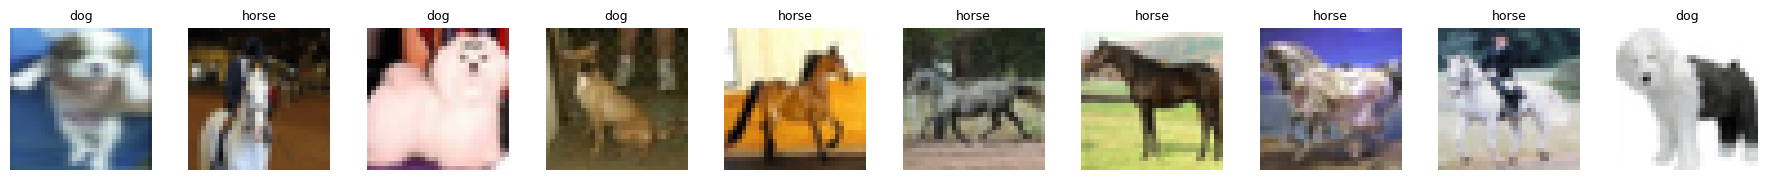

In [4]:
# Load data
data = np.load(DATA_PATH)
X_train = data["X_train"]          # expected shape (N, 32*32*3) or (N, D)
X_train_vis = data["X_train_vis"]  # expected shape (N, 32, 32, 3) for plotting
y_train = data["y_train"]

print("Shapes:", X_train.shape, y_train.shape)  # (N, D), (N,)
# Train/Val split (stratified)
X_tr, X_val, y_tr, y_val, vis_tr, vis_val = train_test_split(
    X_train, y_train, X_train_vis,
    test_size=VAL_SIZE,
    stratify=y_train,
    random_state=42,
)
# sanity-check a few images
visualize_images(vis_tr, y_tr, num_images=10, start_index=10)

In [6]:
# Build pipeline and hyperparam grid
if USE_QDA:
    clf = QuadraticDiscriminantAnalysis()
    param_grid = {
        "pca__n_components": PCA_GRID,# QDA has no main hyperparams to tune here; PCA reduces rank to avoid singular covariance 
    }
else:
    clf = KNeighborsClassifier()
    param_grid = {
        "pca__n_components": PCA_GRID,
        "classifier__n_neighbors": [3, 5, 7, 9, 15],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2],  # Manhattan vs Euclidean
    }

pipe = Pipeline([
    ("scaler", StandardScaler()),      # scale features first
    ("pca", PCA(whiten=False, random_state=42)),
    ("classifier", clf),
])

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# Fit on training fold only, then evaluate on held-out val
search.fit(X_tr, y_tr)

print("\nBest params:", search.best_params_)
print("Best CV accuracy: {:.4f}".format(search.best_score_))

best_model = search.best_estimator_
# Validation performance
y_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)
print("Validation accuracy: {:.4f}".format(val_acc))
print("\nClassification report (validation):\n", classification_report(y_val, y_pred, target_names=[CIFAR10_LABELS[i] for i in sorted(np.unique(y_val))]))
print("Confusion matrix (validation):\n", confusion_matrix(y_val, y_pred))
# plot_incorrect_predictions(vis_val, X_val, y_val, best_model, max_show=15)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params: {'pca__n_components': 40}
Best CV accuracy: 0.7813
Validation accuracy: 0.7700

Classification report (validation):
               precision    recall  f1-score   support

         dog       0.76      0.79      0.77        99
       horse       0.78      0.75      0.77       101

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Confusion matrix (validation):
 [[78 21]
 [25 76]]
